
<div style="align: center;">
    <br>
    <img src="https://media.licdn.com/dms/image/v2/D4D12AQFVzjRWeNpA7w/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1711408967531?e=2147483647&v=beta&t=5MHJ_rGqMoarKpOy6DkK24xaJO01VPyj_piB96MxaLI" style="display:block; margin:auto; width:95%; height:250px;">
    <br>
    <h1 align = 'center'>Segmentación de una base de datos de clientes para ayudar al retailer a mejorar sus resultados desarrollando sus diferentes tipologías de clientes.</h1>
</div>
<div>
    <h3 id="INDICE">INDICE</h3>
    <ul>
        <li><a href="#Exploracion_de_los_datos">Exploración de los datos</a></li>
        <li><a href="#Constuccion_de_indicadores">Construcción de indicadores</a></li>
        <li><a href="#ELaboracion_Life_Time_Value">Elaboración de Live Time Value</a></li>
        <li><a href="#Extraccion_de_informacion_clave">Extracción de información clave</a></li>
    </ul>
</div>


<div>
    <h1 align = 'center' id="Exploracion_de_los_datos">Exploración de los datos</h1>
    <h3><a href="#INDICE">INDICE</a></h3>
</div>

In [2]:
import pandas as pd
# Subimos dos data frames
# Dataframe de ventas
df = pd.read_csv('VENTAS DE LOS CLIENTES DE LA MUESTRA.csv', delimiter='\t')
# Dataframe de tipologias de clientes
df_tipologias = pd.read_csv('TIPOLOGIAS Y ACTIVIDAD DEL CLIENTE.csv', delimiter='\t')

In [19]:
df_tipologias.head(10)

,TIPOLOGIA DE CLIENTE,ACTIVIDAD,CUSTOMER ID
0,b,ACTIVE,920080000720
1,NEVER USED,NEVER USED,920080000784
2,c,ACTIVE,920080000852
3,NEVER USED,NEVER USED,920080001626
4,d,INACTIVE,920080002982
5,b,ACTIVE,920080003478
6,b,ACTIVE,920080003540
7,a,ACTIVE,920080004196
8,a,ACTIVE,920080004730
9,c,ACTIVE,920080005682


<div>
    <h1 id="Constuccion_de_indicadores">Construcción de indicadores</h1>
    <h4><a href="#INDICE">INDICE</a></h4>
</div>

In [105]:
# creamos una copia de los datos
df_datos = df.copy(deep=False)
# Cambiamos el formato de la fecha
df_datos['Purchase_Date'] = pd.to_datetime(df_datos['Purchase_Date'], format='%Y-%m-%d')
# Extraemos el año de la fecha
df_datos['Año'] = df_datos['Purchase_Date'].dt.year
# Convertimos la columna en formato date
df_datos['Purchase_Date'] = df_datos['Purchase_Date'].dt.date
# Calculamos el margen suponiendo que la ganacia es un 40%
df_datos['margen'] = df_datos['Purchase_Amount_euros']*0.40
# Calculamos el gross contribution(GC)
df_datos['GC'] = df_datos['Purchase_Amount_euros'] - df_datos['margen']
# Calculamos t
df_datos['t'] = df_datos['Año'].max()-df_datos['Año']
# PCV por fila
df_datos['PCV por fila'] = df_datos['GC'] * ((1/(1+0.1))**df_datos['t'])

<div>
    <h1 id = "ELaboracion_Life_Time_Value">Elaboración de Life Time Value</h1>
    <h4><a href="#INDICE">INDICE</a></h4>
</div>

<h3>Life Time Value</h3>
<img src="Life Time Value.png">
<p>Esta es la formula que utilizamos para el calculo final.</p>

In [114]:
pcv = df_datos.groupby('CUSTOMER ID').agg(pcv = ('PCV por fila','sum'),
                                    suma_compra =('Purchase_Amount_euros','sum'),
                                    suma_margen = ('margen','sum'),
                                    date_max = ('Purchase_Date', 'max'),
                                    date_min = ('Purchase_Date', 'min'),
                                    Receipt_count = ('Receipt_Number', 'nunique')).reset_index()
pcv['quintil_pcv'] = pd.qcut(pcv['pcv'], 5, labels=['pcv muy bajo', 'pcv bajo', 'pcv medio', 'pcv alto', 'pcv muy alto'])
pcv= pd.merge(pcv, df_tipologias, on='CUSTOMER ID')

<div>
    <h1 id = "Extraccion_de_informacion_clave">Extracción de información clave</h1>
    <h4><a href="#INDICE">INDICE</a></h4>
</div>

In [28]:
tabla_cruzada = pd.crosstab(pcv['quintil_pcv'], pcv['TIPOLOGIA DE CLIENTE'], margins=True)
tabla_cruzada

TIPOLOGIA DE CLIENTE,a,b,c,d,All
quintil_pcv,,,,,
pcv muy bajo,0,0,103,418,521
pcv bajo,0,71,241,209,521
pcv medio,3,247,262,9,521
pcv alto,53,452,16,0,521
pcv muy alto,340,180,1,0,521
All,396,950,623,636,2605


In [29]:
# Se comprueba si la tipologia del cliente y la clasificacion por quintiles tienen una relación significativa
import pandas as pd
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(tabla_cruzada)
print('el valor de chi cudrado es',chi2)
print('el valor de p es',p)
if p < 0.05:
    print("Existe una relación significativa entre las variables.")
else:
    print("No existe una relación significativa entre las variables.")

el valor de chi cudrado es 3305.537742883493
el valor de p es 0.0
Existe una relación significativa entre las variables.


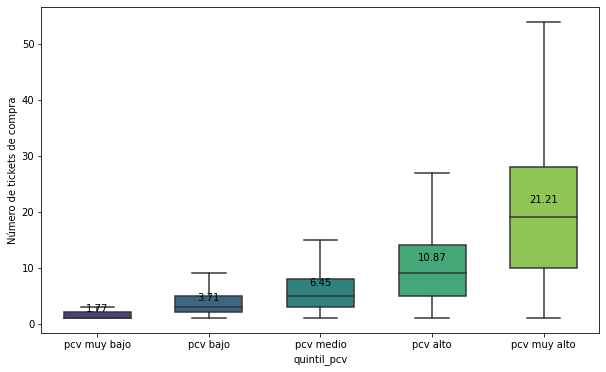

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Quintiles de acuerdo al numero de tickets de compra (Receipt_count)
medias = pcv.groupby('quintil_pcv')['Receipt_count'].mean()
plt.figure(figsize=(10, 6))
sns.boxplot(x='quintil_pcv', y='Receipt_count', data=pcv, palette="viridis", 
            width=0.6, showfliers=False, color='red')
for i in range(len(medias)):
    plt.plot([i, i], [medias[i], medias[i]], color='black', linestyle='--')
for i, mean in enumerate(medias):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom')
plt.ylabel('Número de tickets de compra')
plt.savefig('D:\Proyectos\HTML\proyecto2\img\p5.png', bbox_inches='tight')
plt.show()